In [1]:
%matplotlib inline
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from gravdark import LightCurve, hat7_params, tres2_params, kepler91_params, kepler13_params

h7_path = glob('/Users/bmmorris/data/gravdark/hat7/*slc.fits')
t2_path = glob('/Users/bmmorris/data/gravdark/tres2/*slc.fits')
k91_path = glob('/Users/bmmorris/data/gravdark/kepler91/*llc.fits')
k13_path = glob('/Users/bmmorris/data/gravdark/kepler13/*slc.fits')

In [2]:
h7_lc_whole = LightCurve.from_raw_fits(h7_path, name='HAT-P-7 b')
t2_lc_whole = LightCurve.from_raw_fits(t2_path, name='TrES-2 b')
k91_lc_whole = LightCurve.from_raw_fits(k91_path, name='Kepler-91 b')
k13_lc_whole = LightCurve.from_raw_fits(k13_path, name='Kepler-13 b')

In [3]:
h7_masked = LightCurve(**h7_lc_whole.mask_out_of_transit(hat7_params(), oot_duration_fraction=0.5))
h7_transits = h7_masked.get_transit_light_curves(hat7_params())

t2_masked = LightCurve(**t2_lc_whole.mask_out_of_transit(tres2_params(), oot_duration_fraction=0.5))
t2_transits = t2_masked.get_transit_light_curves(tres2_params())

k91_masked = LightCurve(**k91_lc_whole.mask_out_of_transit(kepler91_params(), oot_duration_fraction=0.5))
k91_transits = k91_masked.get_transit_light_curves(kepler91_params())

k13_masked = LightCurve(**k13_lc_whole.mask_out_of_transit(kepler13_params(), oot_duration_fraction=0.5))
k13_transits = k13_masked.get_transit_light_curves(kepler13_params())

for transits, params in zip([h7_transits, t2_transits, k91_transits, k13_transits], 
                            [hat7_params(), tres2_params(), kepler91_params(), kepler13_params()]):
    for transit in transits:
        transit.remove_linear_baseline(params)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:849: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd1 = apply_method(jd1)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:850: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd2 = apply_method(jd2)
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:373: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  fluxes=self.fluxes[start_ind:end_ind],
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:374: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  errors=self.errors[start_ind:end_ind],
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:375: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an er

In [4]:
from gravdark.lightcurve import concatenate_light_curves

h7 = concatenate_light_curves(h7_transits)
t2 = concatenate_light_curves(t2_transits)
k91 = concatenate_light_curves(k91_transits)
k13 = concatenate_light_curves(k13_transits)

(0.992, 1.001)

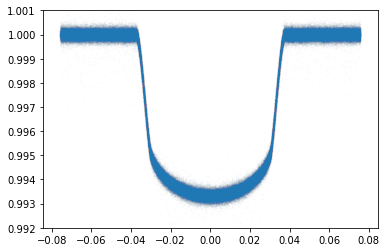

In [5]:
plt.scatter(h7.phases(hat7_params()), h7.fluxes, s=1, alpha=0.01)
plt.ylim([0.992, 1.001])

(0.985, 1.001)

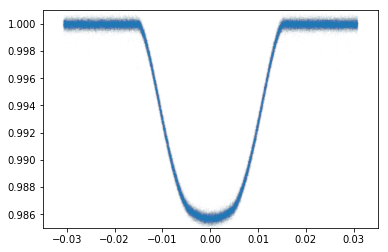

In [6]:
plt.scatter(t2.phases(tres2_params()), t2.fluxes, s=1, alpha=0.01)
plt.ylim([0.985, 1.001])

(0.999, 1.001)

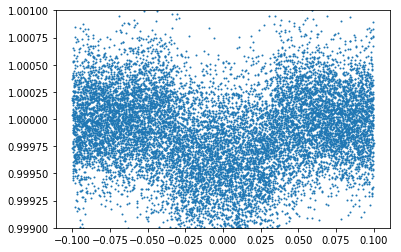

In [7]:
plt.scatter(k91.phases(kepler91_params()), k91.fluxes, s=1, alpha=1)
plt.ylim([0.999, 1.001])

In [8]:
phase = h7.phases(hat7_params())
residuals = h7.fluxes - h7.transit_model(hat7_params())

binstat = binned_statistic(phase, residuals, statistic='median', bins=100)
bincenters = 0.5 * (binstat.bin_edges[1:] + binstat.bin_edges[:-1])

(-0.0001, 0.0001)

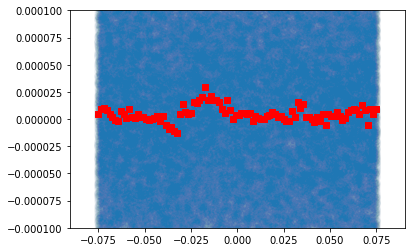

In [9]:
plt.scatter(phase, residuals, alpha=0.01)
plt.scatter(bincenters, binstat.statistic, marker='s', color='r')
plt.ylim([-0.0001, 0.0001])

In [10]:
from scipy.optimize import fmin_powell
import batman

def tweak_params(p):
    t0 = p[0]
    
    params = batman.TransitParams()
    params.t0 = t0     # time of inferior conjunction
    params.per = 2.2047355         # orbital period
    params.rp = 0.077490          # planet radius (in units of stellar radii)
    dur = 0.1669                  # transit duration
    params.inc = 83.119             # orbital inclination (in degrees)

    params.ecc = 0      # eccentricity
    params.w = np.pi/2               # longitude of periastron (in degrees)
    params.a = 4.1512                # semi-major axis (in units of stellar radii)
    params.u = [0.3522, 0.1705]      # limb darkening coefficients
    params.limb_dark = "quadratic" # limb darkening model

    # Required by some friedrich methods below but not by batman:
    params.duration = dur
    return params
    
def chi2(p):
    params = tweak_params(p)
    sq_diff = (h7.fluxes - h7.transit_model(params))**2
    return np.sum(sq_diff)

initp = [54.35780 + 2454900]
results = fmin_powell(chi2, initp)

Optimization terminated successfully.
         Current function value: 0.012137
         Iterations: 2
         Function evaluations: 34


In [11]:
results

array(2454954.358520872)

(-0.0001, 0.0001)

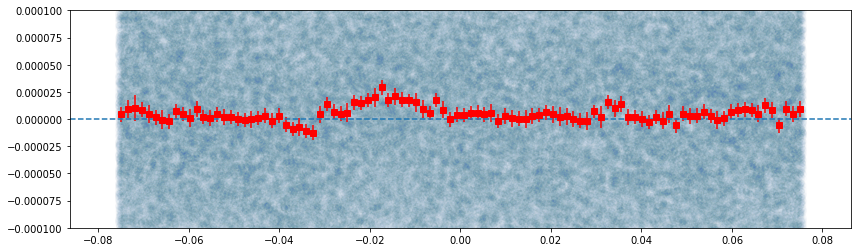

In [12]:
#params = tweak_params([results])
#phase = h7.phases(params)

phase = h7.phases(hat7_params())
residuals = h7.fluxes - h7.transit_model(hat7_params())

binstat = binned_statistic(phase, residuals, statistic='median', bins=100)
errstat = binned_statistic(phase, residuals, statistic='std', bins=100)
countstat = binned_statistic(phase, residuals, statistic='count', bins=100)
error = 2 * errstat.statistic/np.sqrt(countstat.statistic)

bincenters = 0.5 * (binstat.bin_edges[1:] + binstat.bin_edges[:-1])

plt.figure(figsize=(14, 4))
plt.scatter(phase, residuals, alpha=0.01)
#plt.scatter(bincenters, binstat.statistic, marker='s', color='r')
plt.errorbar(bincenters, binstat.statistic, yerr=error, fmt='s', color='r')
plt.axhline(0, ls='--')
plt.ylim([-0.0001, 0.0001])

In [13]:
phase = t2.phases(hat7_params())
residuals = t2.fluxes - t2.transit_model(tres2_params())

binstat = binned_statistic(phase, residuals, statistic='median', bins=50)
bincenters = 0.5 * (binstat.bin_edges[1:] + binstat.bin_edges[:-1])

(-0.0001, 0.0002)

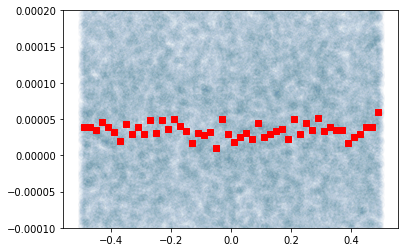

In [14]:
plt.scatter(phase, residuals, alpha=0.01)
plt.scatter(bincenters, binstat.statistic, marker='s', color='r')
plt.ylim([-0.0001, 0.0002])

In [15]:
phase = k91.phases(kepler91_params())
residuals = k91.fluxes - k91.transit_model(kepler91_params(), short_cadence=False)

binstat = binned_statistic(phase, residuals, statistic='median', bins=50)
bincenters = 0.5 * (binstat.bin_edges[1:] + binstat.bin_edges[:-1])

(-0.0002, 0.0002)

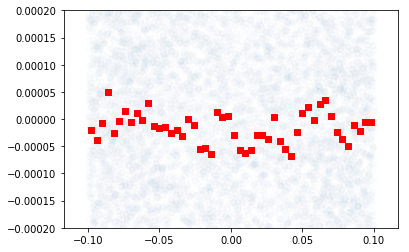

In [16]:
plt.scatter(phase, residuals, alpha=0.01)
plt.scatter(bincenters, binstat.statistic, marker='s', color='r')
plt.ylim([-0.0002, 0.0002])

In [17]:
phase = k13.phases(kepler13_params())
residuals = k13.fluxes - k13.transit_model(kepler13_params())

binstat = binned_statistic(phase, residuals, statistic='median', bins=50)
bincenters = 0.5 * (binstat.bin_edges[1:] + binstat.bin_edges[:-1])

(-0.0002, 0.0002)

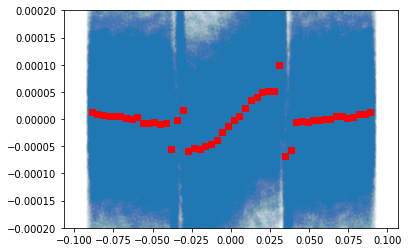

In [18]:
from scipy.optimize import fmin_powell, fmin_l_bfgs_b
import batman

def tweak_params(p):
    depth = p[0]
    t0 = p[1]
    params = batman.TransitParams()
    params.t0 = t0     # time of inferior conjunction
    params.per = 1.763588          # orbital period
    params.rp = np.sqrt(depth)#0.087373         # planet radius (in units of stellar radii)
    dur = 0.14108704                  # transit duration
    params.inc = 86.769          # orbital inclination (in degrees)

    params.ecc = 0.00064     # eccentricity
    params.w = 0               # longitude of periastron (in degrees)
    params.a = 4.5008              # semi-major axis (in units of stellar radii)
    params.u = [0.3183, 0.2024]     # limb darkening coefficients
    params.limb_dark = "quadratic" # limb darkening model

    # Required by some friedrich methods below but not by batman:
    params.duration = dur
    return params
    
def chi2(p):
    params = tweak_params(p)
    sq_diff = (k13.fluxes - k13.transit_model(params))**2
    return np.sum(sq_diff)

initp = [0.087373**2, 120.56596 + 2454833]
results = fmin_l_bfgs_b(chi2, initp, approx_grad=True, 
                        bounds=((0, 1), (120. + 2454833, 121 + 2454833)))[0]

phase = k13.phases(tweak_params(results))
residuals = k13.fluxes - k13.transit_model(tweak_params(results))

binstat = binned_statistic(phase, residuals, statistic='median', bins=50)
bincenters = 0.5 * (binstat.bin_edges[1:] + binstat.bin_edges[:-1])

plt.scatter(phase, residuals, alpha=0.01)
plt.scatter(bincenters, binstat.statistic, marker='s', color='r')
plt.ylim([-0.0002, 0.0002])